In [37]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
import seaborn as sns
sns.set_style("white")

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# My packages
from source import parse_mxml as pm
from source import log_representation as lr
from source import plots as plts
from source import drift_detection as dd
from source import drift_localization as dl
from source import offline_streaming_clustering as off_sc
from sklearn.cluster import KMeans

import random
random.seed(42)

import os
import glob

import gc
gc.enable()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

def if_any(string, lista):
    for l in lista:
        if l in string:
            return True
    return False

In [3]:
logs = insensitive_glob("../process_mining_datasets/*/*k.MXML")

In [4]:
logs = [x for x in logs if "2.5" not in x]

### Read and Prep log file

In [5]:
#Example
logs[1]

'..\\process_mining_datasets\\cb\\cb5k.mxml'

In [6]:
log_read = pm.all_prep(logs[1])
tokens = lr.get_traces_as_tokens(log_read)
y_true = list(range(int(len(tokens)/10), len(tokens), int(len(tokens)/10)))

### Vector space representations

In [7]:
activity_binary = lr.get_binary_representation(tokens)
transitions_binary = lr.get_binary_transitions_representation(tokens)
activity_frequency = lr.get_frequency_representation(tokens)

### Trace Clustering - Transitions Binary

In [8]:
run_df = off_sc.run_offline_clustering_window(
    KMeans(n_clusters=3, random_state=42),
    125,
    transitions_binary,
    sliding_window=False,
    sliding_step=1
)

##### Features from the evolution of trace clustering

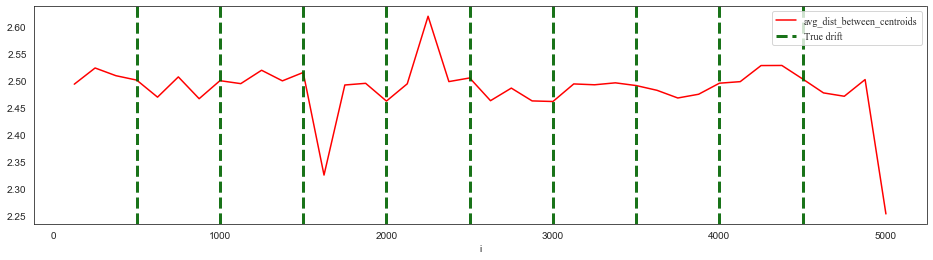

In [9]:
run_df['avg_dist_between_centroids'].plot(figsize=(16,4), c='red')
plts.plot_drift_vertical_lines(len(activity_binary), label="True drift")
plt.legend();

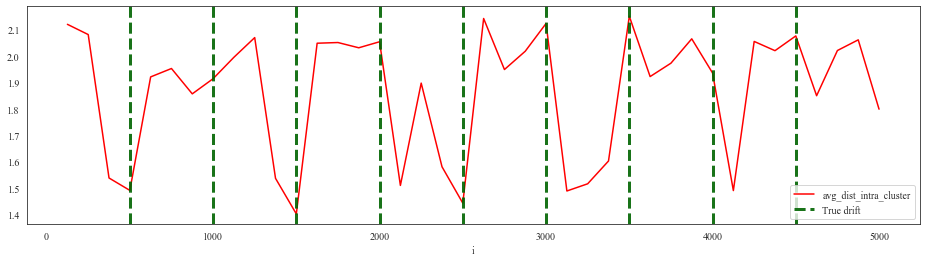

In [10]:
run_df['avg_dist_intra_cluster'].plot(figsize=(16,4), c='red')
plts.plot_drift_vertical_lines(len(activity_binary), label="True drift")
plt.legend();

### Trace Clustering - Activity Binary

In [28]:
clustering_window_size = 125

run_df = off_sc.run_offline_clustering_window(
    KMeans(n_clusters=3, random_state=42),
    clustering_window_size,
    activity_binary,
    sliding_window=False,
    sliding_step=1
)

##### Features from the evolution of trace clustering

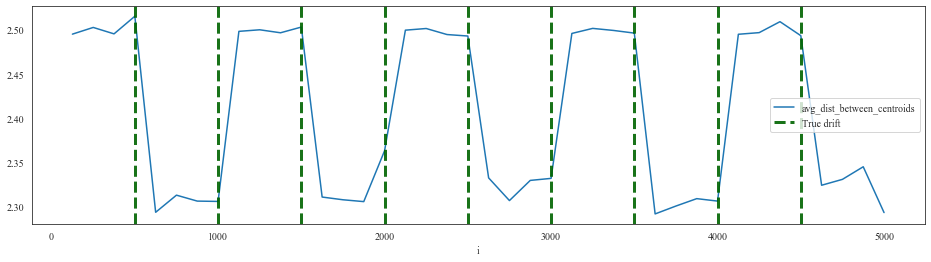

In [12]:
run_df['avg_dist_between_centroids'].plot(figsize=(16,4))
plts.plot_drift_vertical_lines(len(activity_binary), label="True drift")
plt.legend();

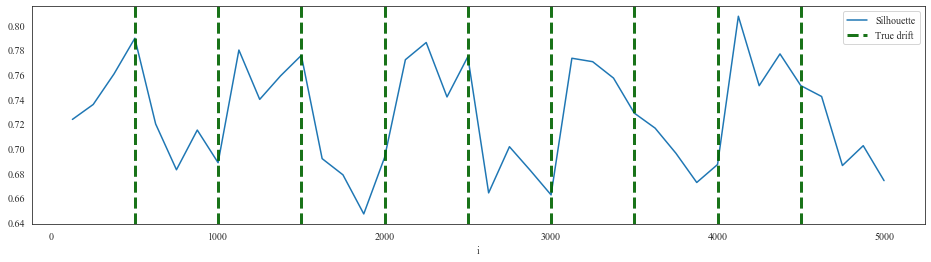

In [13]:
run_df['Silhouette'].plot(figsize=(16,4))
plts.plot_drift_vertical_lines(len(activity_binary), label="True drift")
plt.legend();

### Drift Detection

In [42]:
drifts, info = dd.detect_concept_drift(
    run_df,
    'avg_dist_between_centroids',
    rolling_window=2,
    std_tolerance=2.5,
    min_tol=0.03
)

In [43]:
dd.get_metrics(drifts, y_true, window_size=clustering_window_size)

{'Precision': 1.0,
 'Recall': 1.0,
 'F1': 1.0,
 'Delay': 125.0,
 'Correct_Predictions': [1, 1, 1, 1, 1, 1, 1, 1, 1],
 'Support': 9,
 'Drifts_Found': [625, 1125, 1625, 2125, 2625, 3125, 3625, 4125, 4625],
 'Resp': [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]}

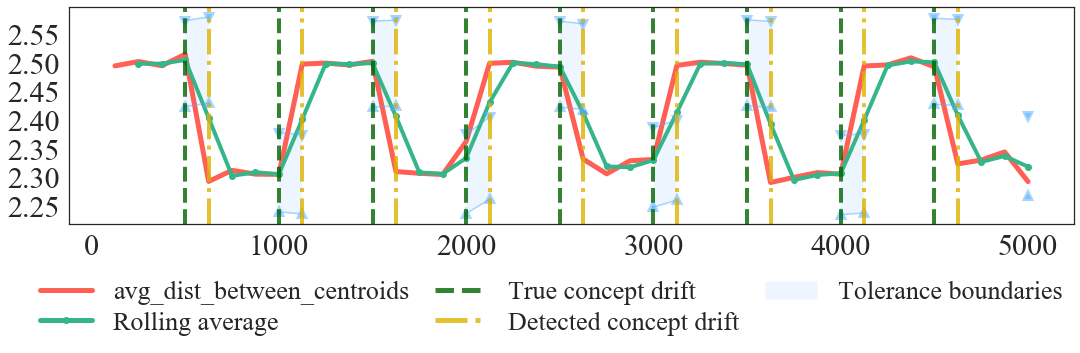

In [44]:
plts.plot_deteccao_drift(
    run_df,
    'avg_dist_between_centroids',
    drifts,
    y_true,
    info['means'],
    info['lowers'],
    info['uppers'],
    save_png=""
)

### Drift Localization

In [45]:
dl.localize_drift(
    run_df.centroids.loc[500], 
    run_df.centroids.loc[625], 
    activity_binary.columns
)

,0
Check_if_home_insurance_quote_is_requested,0.291847
Prepare_acceptance_pack,0.291847
Send_acceptance_pack,0.055744
Send_home_insurance_quote,0.055744
Return_application_back_to_applicant,0.006408
Receive_updated_application,0.006408
Appraise_property,0.000000
Loan__application_received,0.000000
Reject_application,0.000000
Loan_application_rejected,0.000000


In [46]:
# Result of drift localization in the ground truth drifts

dl.localize_all_drifts(
    run_df,
    [x + clustering_window_size for x in y_true], 
    clustering_window_size,
    activity_binary.columns
)

,drift_at_625,drift_at_1125,drift_at_1625,drift_at_2125,drift_at_2625,drift_at_3125,drift_at_3625,drift_at_4125,drift_at_4625
Check_if_home_insurance_quote_is_requested,0.291847,0.178800,0.162058,0.106056,0.117309,0.118831,0.194832,0.190859,0.144066
Prepare_acceptance_pack,0.291847,0.178800,0.162058,0.106056,0.117309,0.118831,0.194832,0.190859,0.144066
Send_acceptance_pack,0.055744,0.009371,0.008542,0.027757,0.005993,0.009591,0.007875,0.009032,0.002299
Send_home_insurance_quote,0.055744,0.009371,0.008542,0.027757,0.005993,0.009591,0.007875,0.009032,0.002299
Return_application_back_to_applicant,0.006408,0.020518,0.011018,0.005978,0.003944,0.003094,0.006355,0.009204,0.002468
Receive_updated_application,0.006408,0.020518,0.011018,0.005978,0.003944,0.003094,0.006355,0.009204,0.002468
Appraise_property,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Loan__application_received,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Reject_application,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Loan_application_rejected,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [47]:
# Result of drift localization in all predicted drifts

dl.localize_all_drifts(
    run_df,
    drifts, 
    clustering_window_size,
    activity_binary.columns
)

,drift_at_625,drift_at_1125,drift_at_1625,drift_at_2125,drift_at_2625,drift_at_3125,drift_at_3625,drift_at_4125,drift_at_4625
Check_if_home_insurance_quote_is_requested,0.291847,0.178800,0.162058,0.106056,0.117309,0.118831,0.194832,0.190859,0.144066
Prepare_acceptance_pack,0.291847,0.178800,0.162058,0.106056,0.117309,0.118831,0.194832,0.190859,0.144066
Send_acceptance_pack,0.055744,0.009371,0.008542,0.027757,0.005993,0.009591,0.007875,0.009032,0.002299
Send_home_insurance_quote,0.055744,0.009371,0.008542,0.027757,0.005993,0.009591,0.007875,0.009032,0.002299
Return_application_back_to_applicant,0.006408,0.020518,0.011018,0.005978,0.003944,0.003094,0.006355,0.009204,0.002468
Receive_updated_application,0.006408,0.020518,0.011018,0.005978,0.003944,0.003094,0.006355,0.009204,0.002468
Appraise_property,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Loan__application_received,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Reject_application,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Loan_application_rejected,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
